# LangGraph quickstart
> [Source](https://langchain-ai.github.io/langgraph/tutorials/introduction/)

# Setup

In [2]:
import getpass
import os
from dotenv import load_dotenv


load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

# Part 1: Build a Basic Chatbot
We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list".
    # The `add_messages` function in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

**Notice** that we've defined our `State` as a `TypedDict` with a single key: `messages`.   
The `messages` key is annotated with the `add_messages` function, which tells LangGraph to append new messages to the existing list, rather than overwriting it.

So now our graph knows two things:
  1. Every `node` we define will receive the current State as input and return a value that updates that state.
  2. `messages` will be _appended_ to the current list, rather than directly overwritten. This is communicated via the prebuilt `add_messages` function in the Annotated syntax.

Next, add a `"chatbot"` node. Nodes represent units of work. They are typically regular python functions.

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo-0125")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

**Notice** how the `chatbot` node function takes the current `State` as input and returns an updated `messages` list. This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.

Next, add an `entry` point. This tells our graph **where to start** its work each time we run it.

In [5]:
graph_builder.add_edge(START, "chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**

In [6]:
graph_builder.add_edge("chatbot", END)

Finally, we'll want to be able to run our graph. To do so, call "`compile()`" on the graph builder. This creates a "`CompiledGraph`" we can use invoke on our state.

In [7]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The draw methods each require additional dependencies.

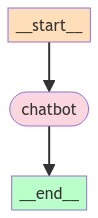

In [8]:
from IPython.display import Image, display


try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now let's run the chatbot!

> **Tip**: You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [9]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print(f'User: "{user_input}"\n')
            print(f'Assistant: {value["messages"][-1].content}\n')

User: "Hello"

Assistant: Hello! How can I assist you today?

Goodbye!


# Part 2: Enhancing the Chatbot with Tools
To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

In [10]:
_set_env("TAVILY_API_KEY")

Define the tool

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults


tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making ...'},
 {'url': 'https://medium.com/@bhavikjikadara/langgraph-a-comprehensive-guide-for-beginners-ef17d3dd5383',
  'content': 'LangGraph is a library for building stateful, multi-actor applications with LLMs. ... We now need to define a few different nodes in our graph. In langgraph, a node can be either a function or a ...'}]

The results are page summaries our chat bot can use to answer questions.

Next, we'll start defining our graph. The following is all the same as in Part 1, except we have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [12]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`. It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt `ToolNode` to speed things up, but building it ourselves first is instructive.

In [13]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

With the tool node added, we can define the `conditional_edges`.

Recall that **edges** route the control flow from one node to the next. **Conditional edges** usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph `state` and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called `route_tools`, that checks for `tool_calls` in the chatbot's output. Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next.

The condition will route to `tools` if tool calls are present and "`__end__`" if not.

Later, we will replace this with the prebuilt `tools_condition` to be more concise, but implementing it ourselves first makes things more clear.

In [14]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

**Notice** that conditional edges start from a single node. This tells the graph "any time the '`chatbot`' node runs, either go to 'tools' if it calls a tool, or end the loop if it responds directly.

Like the prebuilt `tools_condition`, our function returns the "`__end__`" string if no tool calls are made. When the graph transitions to `__end__`, it has no more tasks to complete and ceases execution. Because the condition can return __end__, we don't need to explicitly set a `finish_point` this time. Our graph already has a way to finish!

Let's visualize the graph we've built. The following function has some additional dependencies to run that are unimportant for this tutorial.

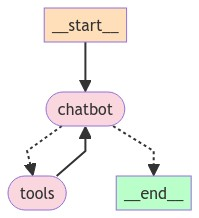

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now we can ask the bot questions outside its training data

In [16]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: Hello! How can I assist you today?
Goodbye!


**Congrats!** You've created a conversational agent in langgraph that can use a search engine to retrieve updated information when needed. Now it can handle a wider range of user queries. To inspect all the steps your agent just took, check out this LangSmith trace.

Our chatbot still can't remember past interactions on its own, limiting its ability to have coherent, multi-turn conversations. In the next part, we'll add **memory** to address this.

# Part 3: Adding Memory to the Chatbot
Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that **checkpointing** is _much_ more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But before we get too ahead of ourselves, let's add checkpointing to enable multi-turn conversations.

To get started, create a `SqliteSaver` checkpointer.

In [18]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

Notice that we've specified `:memory` as the Sqlite DB path. This is convenient for our tutorial (it saves it all in-memory). In a production application, you would likely change this to connect to your own DB and/or use one of the other checkpointer classes.

Next define the graph. Now that you've already built your own `BasicToolNode`, we'll replace it with LangGraph's prebuilt `ToolNode` and `tools_condition`, since these do some nice things like parallel API execution. Apart from that, the following is all copied from Part 2.

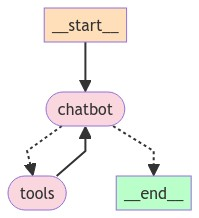

In [20]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


# create the state
class State(TypedDict):
    messages: Annotated[list, add_messages]


# initialise the graph
graph_builder = StateGraph(State)

# define the model and tools
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
llm_with_tools = llm.bind_tools(tools)


# add the chatbot node
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

# add the tool node
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# add the edges
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
# compile the graph with the provided checkpointer
graph = graph_builder.compile(checkpointer=memory)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.

In [21]:
config = {"configurable": {"thread_id": "1"}}

Next, call your chat bot.

In [22]:
user_input = "Hi there! My name is James."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I assist you today?


**Note**: The config was provided as the **second positional argument** when calling our graph. It importantly is _not_ nested within the graph inputs `({'messages': []})`.

Let's ask a followup: see if it remembers your name.

In [23]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Will. How can I help you today, Will?


Notice that we aren't using an external list for memory: it's all handled by the checkpointer! You can inspect the full execution in this LangSmith trace to see what's going on.

Try this using a different config.

In [25]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is {{user.name}}. How can I assist you today?


In [29]:
snapshot = graph.get_state({"configurable": {"thread_id": "1"}})
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', id='b936caa7-a572-45dc-b3a0-ac4074cf5663'), AIMessage(content='Hello Will! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 89, 'total_tokens': 100}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-393cd6ea-da4f-41e7-96dd-c43865ccc6ef-0', usage_metadata={'input_tokens': 89, 'output_tokens': 11, 'total_tokens': 100}), HumanMessage(content='Remember my name?', id='09c2dd89-4588-46ff-ae4b-93b335cfb563'), AIMessage(content='Yes, I remember your name is Will. How can I help you today, Will?', response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 111, 'total_tokens': 130}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-ef2f2960-e12d-411e-8647-9562b355e792-0', usage_metadata={'input_tokens': 11

**Notice** that the **only** change we've made is to modify the `thread_id` in the config. See this call's LangSmith trace for comparison.

By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's `state` for a given config at any time, call `get_state(config)`.

In [30]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

The snapshot above contains the current state values, corresponding config, and the `next` node to process. In our case, the graph has reached an `__end__` state, so `next` is empty.

**Congratulations!** Your chatbot can now maintain conversation state across sessions thanks to LangGraph's checkpointing system. This opens up exciting possibilities for more natural, contextual interactions. LangGraph's checkpointing even handles **arbitrarily complex graph states**, which is much more expressive and powerful than simple chat memory.

In the next part, we'll introduce human oversight to our bot to handle situations where it may need guidance or verification before proceeding.

Check out the code snippet below to review our graph from this section.

# Part 4: Human-in-the-loop
Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph supports `human-in-the-loop` workflows in a number of ways. In this section, we will use LangGraph's `interrupt_before` functionality to always break the tool node.

First, start from our existing code. The following is copied from Part 3.

In [31]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


# create the state
class State(TypedDict):
    messages: Annotated[list, add_messages]


# initialise the graph
graph_builder = StateGraph(State)

# define the model and tools
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
llm_with_tools = llm.bind_tools(tools)


# add the chatbot node
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

# add the tool node
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# add the edges
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Now, compile the graph, specifying to `interrupt_before` the action node.

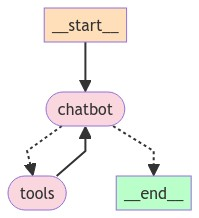

In [32]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)

display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_yMsxmmSseuYdZbPyG3Cb2T3O)
 Call ID: call_yMsxmmSseuYdZbPyG3Cb2T3O
  Args:
    query: LangGraph


Let's inspect the graph state to confirm it worked.

In [34]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

**Notice** that unlike last time, the "next" node is set to '**tools**'. We've interrupted here! Let's check the tool invocation.

In [35]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'call_yMsxmmSseuYdZbPyG3Cb2T3O'}]

This query seems reasonable. Nothing to filter here. The simplest thing the human can do is just let the graph continue executing. Let's do that below.

Next, continue the graph! Passing in `None` will just let the graph continue where it left off, without adding anything new to the state.

In [36]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures ..."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs using regular python functions or JS. Learn how to create graphs with nodes, edges, state, tools, and conditional edges for agentic behaviors."}]
================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs. It is used to create

Review this call's [LangSmith trace](https://smith.langchain.com/) to see the exact work that was done in the above call. Notice that the state is loaded in the first step so that your chatbot can continue where it left off.

**Congrats!** You've used an `interrupt` to add human-in-the-loop execution to your chatbot, allowing for human oversight and intervention when needed. This opens up the potential UIs you can create with your AI systems. Since we have already added a **checkpointer**, the graph can be paused **indefinitely** and resumed at any time as if nothing had happened.

Next, we'll explore how to further customize the bot's behavior using custom state updates.

# Part 5: Manually Updating the State
In the previous section, we showed how to interrupt a graph so that a human could inspect its actions. This lets the human `read` the state, but if they want to change they agent's course, they'll need to have `write` access.

Thankfully, LangGraph lets you **manually update state**! Updating the state lets you control the agent's trajectory by modifying its actions (even modifying the past!). This capability is particularly useful when you want to correct the agent's mistakes, explore alternative paths, or guide the agent towards a specific goal.

We'll show how to update a checkpointed state below. As before, first, define your graph. We'll reuse the exact same graph as before.

In [37]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


# create the state
class State(TypedDict):
    messages: Annotated[list, add_messages]


# initialise the graph
graph_builder = StateGraph(State)

# define the model and tools
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
llm_with_tools = llm.bind_tools(tools)


# add the chatbot node
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

# add the tool node
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# add the edges
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [38]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_ZTw6G5OhO3hE1FUsBA49aelm)
 Call ID: call_ZTw6G5OhO3hE1FUsBA49aelm
  Args:
    query: LangGraph


So far, all of this is an _exact repeat_ of the previous section. The LLM just requested to use the search engine tool and our graph was interrupted. If we proceed as before, the tool will be called to search the web.

But what if the user wants to intercede? What if we think the chat bot doesn't need to use the tool?

Let's directly provide the correct response!

In [39]:
from langchain_core.messages import AIMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='08500777-891d-4bff-b52e-38efe7162454', tool_call_id='call_ZTw6G5OhO3hE1FUsBA49aelm'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='f5cc2b3e-5e07-4faf-90f8-815560e09d9a')]


Now the graph is complete, since we've provided the final response message! Since state updates simulate a graph step, they even generate corresponding traces. Inspec the LangSmith trace of the `update_state` call above to see what's going on.

**Notice** that our new messages are appended to the messages already in the state. Remember how we defined the `State` type?
```python
class Stage(TypedDict):
    messages: Annotated[List[str], add_messages]
```

We annotated `messages` with the pre-built `add_messages` function. This instructs the graph to always append values to the existing list, rather than overwriting the list directly. The same logic is applied here, so the messages we passed to `update_state` were appended in the same way!

The `update_state` function operates as if it were one of the nodes in your graph! By default, the update operation uses the node that was last executed, but you can manually specify it below. Let's add an update and tell the graph to treat it as if it came from the "chatbot".

In [40]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef38d59-61f0-6422-8003-c65a73f088e9'}}

Check out the LangSmith trace for this update call at the provided link. **Notice** from the trace that the graph continues into the `tools_condition` edge. We just told the graph to treat the update `as_node="chatbot"`. If we follow the diagram below and start from the `chatbot` node, we naturally end up in the `tools_condition` edge and then `__end__` since our updated message lacks tool calls.

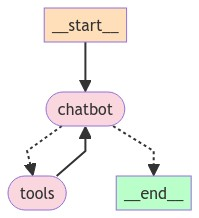

In [41]:
display(Image(graph.get_graph().draw_mermaid_png()))

Inspect the current state as before to confirm the checkpoint reflects our manual updates.

In [42]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='08500777-891d-4bff-b52e-38efe7162454', tool_call_id='call_ZTw6G5OhO3hE1FUsBA49aelm'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='f5cc2b3e-5e07-4faf-90f8-815560e09d9a'), AIMessage(content="I'm an AI expert!", id='4e718953-4515-495e-849e-6bfc9f1197b1')]
()


**Notice**: that we've continued to add AI messages to the state. Since we are acting as the `chatbot` and responding with an AIMessage that doesn't contain `tool_calls`, the graph knows that it has entered a finished state (`next` is empty).

**What if you want to overwrite existing messages?**   
The `add_messages` function we used to annotate our graph's `State` above controls how updates are made to the messages key. This function looks at any message IDs in the new messages list. If the ID matches a message in the existing state, `add_messages` overwrites the existing message with the new content.

As an example, let's update the tool invocation to make sure we get good results from our search engine! First, start a new thread:

In [43]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_spTRqz1ASeXPl4BewnoXONAO)
 Call ID: call_spTRqz1ASeXPl4BewnoXONAO
  Args:
    query: LangGraph


**Next**, let's update the tool invocation for our agent. Maybe we want to search for human-in-the-loop workflows in particular.

In [44]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-aeb0c9dc-0b40-43bf-8750-93a4ab9e11c9-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'call_spTRqz1ASeXPl4BewnoXONAO'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'call_spTRqz1ASeXPl4BewnoXONAO'}
Message ID run-aeb0c9dc-0b40-43bf-8750-93a4ab9e11c9-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'call_spTRqz1ASeXPl4BewnoXONAO'}]

**Notice** that we've modified the AI's tool invocation to search for "LangGraph human-in-the-loop workflow" instead of the simple "LangGraph".

Check out the LangSmith trace to see the state update call - you can see our new message has successfully updated the previous AI message.

Resume the graph by streaming with an input of `None` and the existing config.

In [45]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph/blob/main/examples/human-in-the-loop.ipynb", "content": "human-in-the-loop.ipynb. Cannot retrieve latest commit at this time. History. Preview. Blame. 980 lines (980 loc) \u00b7 45.7 KB. Build resilient language agents as graphs. Contribute to langchain-ai/langgraph development by creating an account on GitHub."}, {"url": "https://langchain-ai.github.io/langgraphjs/how-tos/human-in-the-loop/", "content": "Human-in-the-loop. When creating LangGraph agents, it is often nice to add a human in the loop component. This can be helpful when giving them access to tools. Often in these situations you may want to manually approve an action before taking. This can be in several ways, but the primary supported way is to add an \"interrupt\" before a node is ..."}]
================================== Ai Message ========================

Check out the trace to see the tool call and later LLM response. **Notice** that now the graph queries the search engine using our updated query term - we were able to manually override the LLM's search here!

All of this is reflected in the graph's checkpointed memory, meaning if we continue the conversation, it will recall all the _modified_ state.

In [46]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================

You are learning about LangGraph and its human-in-the-loop workflow.


**Congratulations!** You've used `interrupt_before` and `update_state` to manually modify the state as a part of a human-in-the-loop workflow. Interruptions and state modifications let you control how the agent behaves. Combined with persistent checkpointing, it means you can pause an action and `resume` at any point. Your user doesn't have to be available when the graph interrupts!

The graph code for this section is identical to previous ones. The key snippets to remember are to add `.compile(..., interrupt_before=[...])` (or `interrupt_after`) if you want to explicitly pause the graph whenever it reaches a node. Then you can use `update_state` to modify the checkpoint and control how the graph should proceed.

# Other sections
  - [**Part 6: Customizing State**](https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-6-customizing-state)
  - [**Part 7: Time Travel**](https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-7-time-travel)